# imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import linalg
import scipy.stats as sts 
from matplotlib.gridspec import GridSpec
import seaborn as sns
import warnings
import matplotlib.cbook
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
from joblib import Parallel, delayed  
import multiprocessing
num_cores = multiprocessing.cpu_count()
from tqdm import tqdm
from scipy.stats import ttest_1samp
import scipy.ndimage

%load_ext autoreload
%autoreload 2

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore",category=UserWarning)
np.set_printoptions(suppress=True)
from scikits import bootstrap
from sklearn.linear_model import LogisticRegression as lreg



sns.set_context("talk", font_scale=0.9)
sns.set_style({"ytick.direction": "in"})
sns.set_style({"xtick.direction": "in"})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


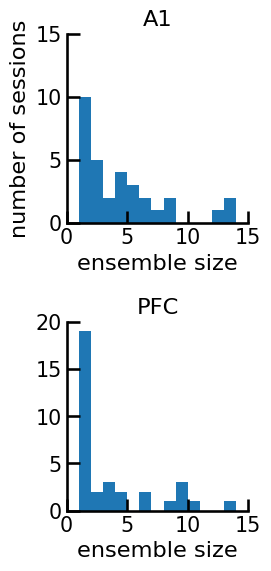

In [6]:
df_A1 = pd.read_csv("../Data/RW_dataframe_A1_nozscore_smooth.csv")
df_A1 = pd.read_csv("../Data/RW_dataframe_A1_nozscore_10ms.csv")
# df_A1 = pd.read_csv("../Data/RW_dataframe_A1_nozscore_25ms.csv")

df_PFC = pd.read_csv("../Data/RW_dataframe_PFC_nozscore_smooth.csv")
df_PFC = pd.read_csv("../Data/RW_dataframe_PFC_nozscore_25ms.csv")
df_PFC = pd.read_csv("../Data/RW_dataframe_PFC_nozscore_10ms_errors.csv")

time = np.loadtxt("../Data/time_25ms.txt")
time = np.loadtxt("../Data/time_10ms.txt")

stim_idx = (time>=0) & (time<=0.25)

a1_s = [s.split("_")[1] for s in df_A1.sessions_id.unique()]
pfc_s = [s.split("_")[1] for s in df_PFC.sessions_id.unique()]

a1_common_idx = [s in set(a1_s).intersection(set(pfc_s)) for s in a1_s]
pfc_common_idx = [s in set(a1_s).intersection(set(pfc_s)) for s in pfc_s]



plt.figure(figsize=(3,6))
plt.subplot(2,1,1)
plt.title("A1")
plt.hist(df_A1.groupby("sessions_id").neuron_id.unique().apply(len).values,bins=range(15))
plt.xlim(0,15)
plt.xticks([0,5,10,15])
plt.xlabel("ensemble size")
plt.ylabel("number of sessions")
plt.ylim(0,15)

plt.subplot(2,1,2)
plt.title("PFC")
plt.hist(df_PFC.groupby("sessions_id").neuron_id.unique().apply(len).values,bins=range(15))
plt.xlim(0,15)
plt.xticks([0,5,10,15])
plt.xlabel("ensemble size")
plt.ylim(0,20)

#plt.subplot(2,2,3)
#plt.title("A1 sim. w/ PFC")
#plt.hist(df_A1.groupby("sessions_id").neuron_id.unique().apply(len).values[a1_common_idx],bins=range(15))
#plt.xlim(0,15)
#plt.xlabel("ensemble size")
#plt.ylabel("number of sessions")

#plt.subplot(2,2,4)
#plt.title("PFC sim. w/ A1")
#plt.hist(df_PFC.groupby("sessions_id").neuron_id.unique().apply(len).values[pfc_common_idx],bins=range(15))
#plt.xlim(0,15)

plt.tight_layout()
sns.despine()

dec_beg, dec_end = 9,25

dec_range = np.where((time > -0.5) & (time<0.25))[0]


In [33]:

def df_train_test_split(df,target,n_pseudo_trials,test_size=.5):

    bin_idx = np.where(["bin" in c for c in df.columns])[0]

    all_data_train = []
    all_data_test = []


    labels = df[target].unique()
    n=0
    for _, data_n in df.groupby("neuron_id"):
        n += 1 

        if test_size > 0:
            neuron_train, neuron_test = train_test_split(data_n, test_size=test_size)
        else:
            neuron_train=data_n.copy()
            neuron_test=data_n.copy()

        samples_train = []
        samples_test = []

        for label in labels:

            samples_train.append(neuron_train[neuron_train[target] == label].sample(n=n_pseudo_trials,replace=True))
            samples_test.append(neuron_test[neuron_test[target] == label].sample(n=n_pseudo_trials,replace=True))

        sample = pd.concat(samples_train)
        all_data_train.append(sample.values[:,bin_idx])

        sample = pd.concat(samples_test)
        all_data_test.append(sample.values[:,bin_idx])

    #train_labels = np.concatenate([np.ones(n_pseudo_trials)*labels[0],np.ones(n_pseudo_trials)*labels[1]])
    #test_labels = np.concatenate([np.ones(n_pseudo_trials)*labels[0],np.ones(n_pseudo_trials)*labels[1]])

    #train_labels = np.concatenate([np.ones(n_pseudo_trials)*label for label in labels])
    #test_labels = np.concatenate([np.ones(n_pseudo_trials)*label for label in labels])

    train_labels = np.concatenate([n_pseudo_trials*[label] for label in labels])
    test_labels = np.concatenate([n_pseudo_trials*[label] for label in labels])


    return np.array(all_data_train), np.array(all_data_test),train_labels,test_labels
                
def normalize_vec(v):
    return v / np.linalg.norm(v)
    

def gram_schmidt_1(v,vecs):
    v = v.copy()
    for i in range(len(vecs)):
        v1 = normalize_vec(vecs[i])
        v = v - (v @ v1) * v1
    return v

## decode location and pitch in different contexts

In [34]:

clf = lreg()

folds = 10 #400
n_pseudo_trials = 50

shuffle = False
pd.set_option('mode.chained_assignment', None)

for ai,df_area in enumerate([df_A1,df_PFC]):

    all_decs = np.zeros([folds,4,2,len(dec_range)])
    for ti,target in enumerate(["IA", "IB", "context"]):
        for context in [1,2]:
            print(ai,target, context)

            df = df_area.query("context == %i" % context)

            if target in ["context","decision"]:
                # skip decoding twice
                if context == 2: continue 

                df = df_area.copy()

                #if target == "decision":
                #    df = df.query('decision != 0')


            for fold in tqdm(range(folds)):
                if shuffle: df.loc[:,target] = df[target].sample(frac=1).values
                
                scores = []
                spcounts_train, spcounts_test,labels_train,labels_test = df_train_test_split(df,target,n_pseudo_trials)
                spcounts_train =  scipy.ndimage.gaussian_filter1d(np.array(spcounts_train,dtype=float), .75, axis=-1, mode='constant', cval=0)
                spcounts_test = scipy.ndimage.gaussian_filter1d(np.array(spcounts_test,dtype=float), .75, axis=-1, mode='constant', cval=0)

                for t in dec_range:
                    clf.fit(spcounts_train[:,:,t].T,labels_train)
                    scores.append(clf.score(spcounts_test[:,:,t].T,labels_test))

                all_decs[fold,ti,context-1,:] = scores


    #copy decoding for context to the 2 context, for easier ploting 
    all_decs[:,2,1,:] = all_decs[:,2,0,:]


    # if shuffle:
    #     f = open("../Data/decoders/test/test_pseudo_regression_%s_shuffle.pickle" % (ai +1),"wb")
    #     pickle.dump(all_decs,f)
    # else:
    #     f = open("../Data/decoders/test/test_pseudo_regression_%s.pickle" % (ai+1),"wb")
    #     pickle.dump(all_decs,f)



  0%|          | 0/10 [00:00<?, ?it/s]

0 decision 1


100%|██████████| 10/10 [00:48<00:00,  4.80s/it]

0 decision 2


In [25]:
# f = open("../Data/decoders/test/test_pseudo_regression_1.pickle","rb")
# all_decs1 = pickle.load(f)

# f = open("../Data/decoders/test/test_pseudo_regression_2.pickle","rb")
# all_decs2 = pickle.load(f)

all_decs = np.array([all_decs,all_decs])

# f = open("../Data/decoders/pseudo_regression_A1_PFC_dec_25ms.pickle","wb")
# pickle.dump(all_decs,f)
# f.close()

In [10]:
# f = open("../Data/decoders/pseudo_regression_A1_PFC_dec.pickle","rb")
# all_decs = pickle.load(f)

f = open("../Data/decoders/pseudo_regression_A1_PFC_dec_shuffle.pickle","rb")
all_decs_shuffle = pickle.load(f)


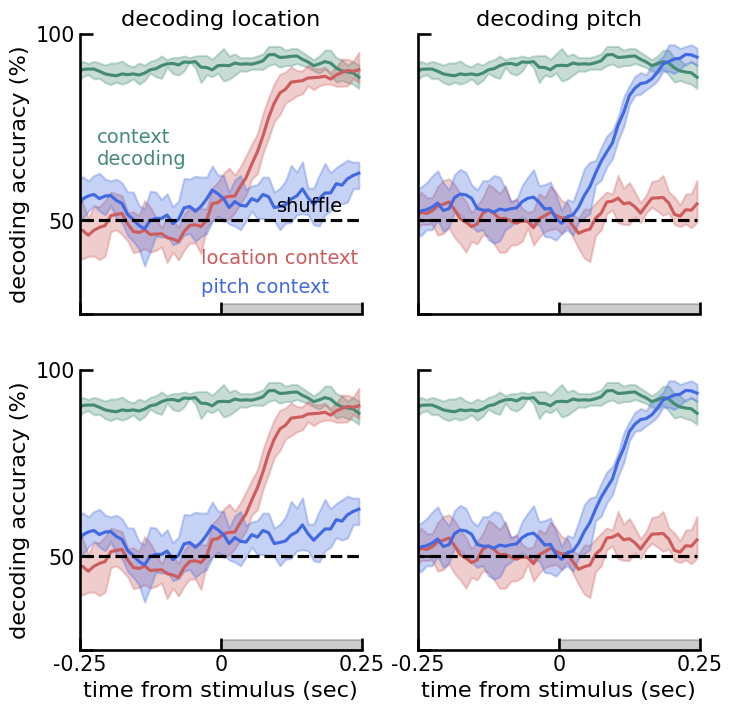

In [26]:
fig = plt.figure(figsize=(8,8))

for ai,area in enumerate(["A1", "PFC"]):

    for i in [0,1]:
        plt.subplot(2,2,ai*2+i+1)

        err_bars_ctx = np.array([np.percentile(a,[16,84]) for a in all_decs[ai,:,2,0].T])
        plt.fill_between(time[dec_range],err_bars_ctx[:,0],err_bars_ctx[:,1],color="#458b74",alpha=0.3)
        plt.plot(time[dec_range],np.mean(all_decs[ai,:,2,0],0),color="#458b74")

        err_bars = np.array([np.percentile(a,[16,84]) for a in all_decs[ai,:,i,0].T])
        plt.fill_between(time[dec_range],err_bars[:,0],err_bars[:,1],color="indianred",alpha=0.3,label="location context")
        plt.plot(time[dec_range],np.mean(all_decs[ai,:,i,0],0),color="indianred")

        err_bars = np.array([np.percentile(a,[16,84]) for a in all_decs[ai,:,i,1].T])
        plt.fill_between(time[dec_range],err_bars[:,0],err_bars[:,1],color="royalblue",alpha=0.3,label="pitch context")
        plt.plot(time[dec_range],np.mean(all_decs[ai,:,i,1],0),color="royalblue")

        # plot shuffles
        # for k in range(3):
        #     err_bars_shuffle = np.array([np.percentile(a,[16,84]) for a in all_decs_shuffle[ai,:,k,i].T])
        #     plt.fill_between(time[dec_range],err_bars_shuffle[:,0],err_bars_shuffle[:,1],color="gray",alpha=0.05)
        #     err_bars_shuffle = np.array([np.percentile(a,[16,84]) for a in all_decs_shuffle[ai,:,k,i].T])
        #     plt.fill_between(time[dec_range],err_bars_shuffle[:,0],err_bars_shuffle[:,1],color="gray",alpha=0.05)
            


        plt.fill_between([0,.25],[0.25,0.25],[.275,.275],color="black",alpha=0.2)
        plt.ylim(0.25,1)
        plt.yticks([0.25,0.5,1],[])
        plt.xlim(-0.25,0.25)
        plt.xticks([-0.25,0,0.25],[])
        plt.plot(time[dec_range],np.ones_like(time[dec_range])*0.5,"k--")
        sns.despine()

        if ai == 0:
            if i==0:

                plt.title("decoding location")

                ax = plt.legend(bbox_to_anchor=(0.175, 0., 0.5, 0.45),frameon=False,fontsize=14)

                texts = ax.get_texts()
                texts[0].set_color("#458b74")
                texts[0].set_color('indianred')

                texts[1].set_color('royalblue')

                for item in ax.legendHandles: 
                    item.set_visible(False)

                plt.text(-0.22,.65,"context\ndecoding",color="#458b74",fontsize=14)
                plt.text(0.1,0.525,"shuffle",color="black",fontsize=14)

            else: 
                plt.title("decoding pitch")
        else: 
            plt.xlabel("time from stimulus (sec)")
            plt.xticks([-0.25,0,0.25],[-0.25,0,0.25])

        if i == 0: 
            plt.ylabel("decoding accuracy (%)")
            plt.yticks([0.25,0.5,1],["",50,100])
        

#plt.tight_layout()
# plt.savefig("figures/paper/FigS1_decoding_location_pitch.svg")
# plt.savefig("figures/paper/FigS1_decoding_location_pitch.png",dpi=300)

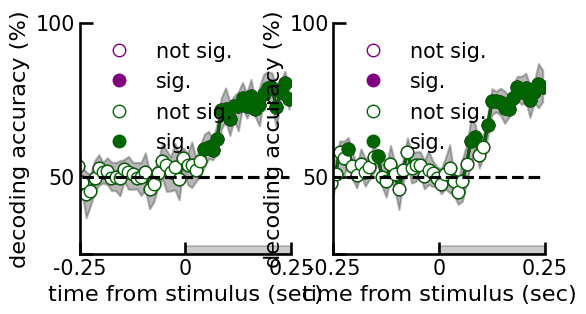

In [12]:
plt.figure(figsize=(6,3))
markers = ['o','s']
colors = ['purple','darkgreen']
labels = ['A1', 'mPFC']

for i in [0,1]:
    plt.subplot(1,2,i+1)
    for ai in [0,1]:
        ps = np.array([np.percentile(a,2.5) for a in all_decs[ai,:,i,i].T])>.5
        err_bars = np.array([np.percentile(a,[16,84]) for a in all_decs[ai,:,i,i].T])
        plt.fill_between(time[dec_range],err_bars[:,0],err_bars[:,1],color=colors[ai],alpha=0.2)
        plt.plot(time[dec_range],np.mean(all_decs[ai,:,i,i],0),color=colors[ai])
        plt.plot(time[dec_range],np.mean(all_decs[ai,:,i,i],0),"o",markerfacecolor='white',color=colors[ai], label="not sig.")
        plt.plot(time[dec_range][ps],np.mean(all_decs[ai,:,i,i],0)[ps],"o",color=colors[ai], label="sig.")

    plt.fill_between([0,.25],[0.25,0.25],[.275,.275],color="black",alpha=0.2)
    plt.ylim(0.25,1)
    plt.yticks([0.25,0.5,1],[])
    plt.xlim(-0.2,0.2)
    plt.xticks([-0.2,0,0.2],[])
    plt.plot(time[dec_range],np.ones_like(time[dec_range])*0.5,"k--")

    plt.xlabel("time from stimulus (sec)")
    plt.xticks([-0.25,0,0.25],[-0.25,0,0.25])

    plt.ylabel("decoding accuracy (%)")
    plt.yticks([0.25,0.5,1],["",50,100])
    plt.legend(frameon=False)

    sns.despine()

#plt.savefig("figures/Fi5_decoding.svg")


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=af3700bb-635f-4f56-95cc-6d24931ab29c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

In [13]:
time[dec_range]

array([-0.495, -0.485, -0.475, -0.465, -0.455, -0.445, -0.435, -0.425,
       -0.415, -0.405, -0.395, -0.385, -0.375, -0.365, -0.355, -0.345,
       -0.335, -0.325, -0.315, -0.305, -0.295, -0.285, -0.275, -0.265,
       -0.255, -0.245, -0.235, -0.225, -0.215, -0.205, -0.195, -0.185,
       -0.175, -0.165, -0.155, -0.145, -0.135, -0.125, -0.115, -0.105,
       -0.095, -0.085, -0.075, -0.065, -0.055, -0.045, -0.035, -0.025,
       -0.015, -0.005,  0.005,  0.015,  0.025,  0.035,  0.045,  0.055,
        0.065,  0.075,  0.085,  0.095,  0.105,  0.115,  0.125,  0.135,
        0.145,  0.155,  0.165,  0.175,  0.185,  0.195,  0.205,  0.215,
        0.225,  0.235,  0.245])

In [14]:
len(time)

200